# Visualization

This notebook walks through how to visualize the graphs you create. This works with ANY [Graph](https://langchain-ai.github.io/langgraph/reference/graphs/).

In [ ]:
%%capture --no-stderr
%pip install -U langgraph

## Set up Graph

You can visualize any arbitrary Graph, including StateGraph's and MessageGraph's. Let's have some fun by drawing fractals :).

In [1]:
import random
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict
from typing import Annotated, Literal


class State(TypedDict):
    messages: Annotated[list, add_messages]


class MyNode:
    def __init__(self, name: str):
        self.name = name

    def __call__(self, state: State):
        return {"messages": [("assistant", f"Called node {self.name}")]}


def route(state) -> Literal["entry_node", "__end__"]:
    if len(state["messages"]) > 10:
        return "__end__"
    return "entry_node"


def add_fractal_nodes(builder, current_node, level, max_level):
    if level > max_level:
        return

    # Number of nodes to create at this level
    num_nodes = random.randint(1, 3)  # Adjust randomness as needed
    for i in range(num_nodes):
        nm = ["A", "B", "C"][i]
        node_name = f"node_{current_node}_{nm}"
        builder.add_node(node_name, MyNode(node_name))
        builder.add_edge(current_node, node_name)

        # Recursively add more nodes
        r = random.random()
        if r > 0.2 and level + 1 < max_level:
            add_fractal_nodes(builder, node_name, level + 1, max_level)
        elif r > 0.05:
            builder.add_conditional_edges(node_name, route, node_name)
        else:
            # End
            builder.add_edge(node_name, "__end__")


def build_fractal_graph(max_level: int):
    builder = StateGraph(State)
    entry_point = "entry_node"
    builder.add_node(entry_point, MyNode(entry_point))
    builder.add_edge("__start__", entry_point)

    add_fractal_nodes(builder, entry_point, 1, max_level)

    # Optional: set a finish point if required
    builder.add_edge(entry_point, "__end__")  # or any specific node

    return builder.compile()


app = build_fractal_graph(3)

## Ascii

We can easily visualize this graph in ascii

In [2]:
app.get_graph().print_ascii()

                                                                           +-----------+                                                               
                                                                           | __start__ |                                                               
                                                                           +-----------+                                                               
                                                                                  *                                                                    
                                                                                  *                                                                    
                                                                                  *                                                                    
                                                                          +------------+

## Mermaid

We can also convert a graph class into Mermaid syntax.

In [3]:
print(app.get_graph().draw_mermaid())

%%{init: {'flowchart': {'curve': 'linear'}}}%%
graph TD;
	__start__[__start__]:::startclass;
	__end__[__end__]:::endclass;
	entry_node([entry_node]):::otherclass;
	node_entry_node_A([node_entry_node_A]):::otherclass;
	node_entry_node_B([node_entry_node_B]):::otherclass;
	node_node_entry_node_B_A([node_node_entry_node_B_A]):::otherclass;
	node_node_entry_node_B_B([node_node_entry_node_B_B]):::otherclass;
	__start__ --> entry_node;
	entry_node --> __end__;
	entry_node --> node_entry_node_A;
	entry_node --> node_entry_node_B;
	node_entry_node_B --> node_node_entry_node_B_A;
	node_entry_node_B --> node_node_entry_node_B_B;
	node_node_entry_node_B_A --> __end__;
	node_entry_node_A -.-> entry_node;
	node_entry_node_A -.-> __end__;
	node_node_entry_node_B_B -.-> entry_node;
	node_node_entry_node_B_B -.-> __end__;
	classDef startclass fill:#ffdfba;
	classDef endclass fill:#baffc9;
	classDef otherclass fill:#fad7de;



## PNG

If preferred, we could render the Graph into a  `.png`. Here we could use three options:

- Using Mermaid.ink API (does not require additional packages)
- Using Mermaid + Pyppeteer (requires `pip install pyppeteer`)
- Using graphviz (which requires `pip install graphviz`)


### Using Mermaid.Ink

By default, `draw_mermaid_png()` uses Mermaid.Ink's API to generate the diagram.

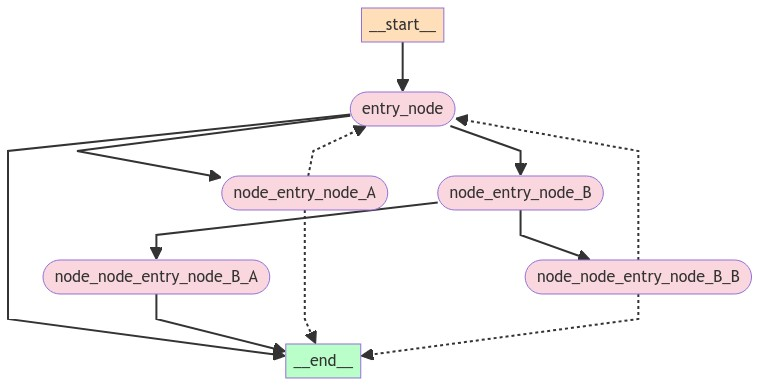

In [4]:
from langchain_core.runnables.graph import CurveStyle, NodeColors, MermaidDrawMethod
from IPython.display import display, HTML, Image

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

### Using Mermaid + Pyppeteer

In [5]:
%%capture --no-stderr
%pip install --quiet pyppeteer
%pip install --quiet nest_asyncio

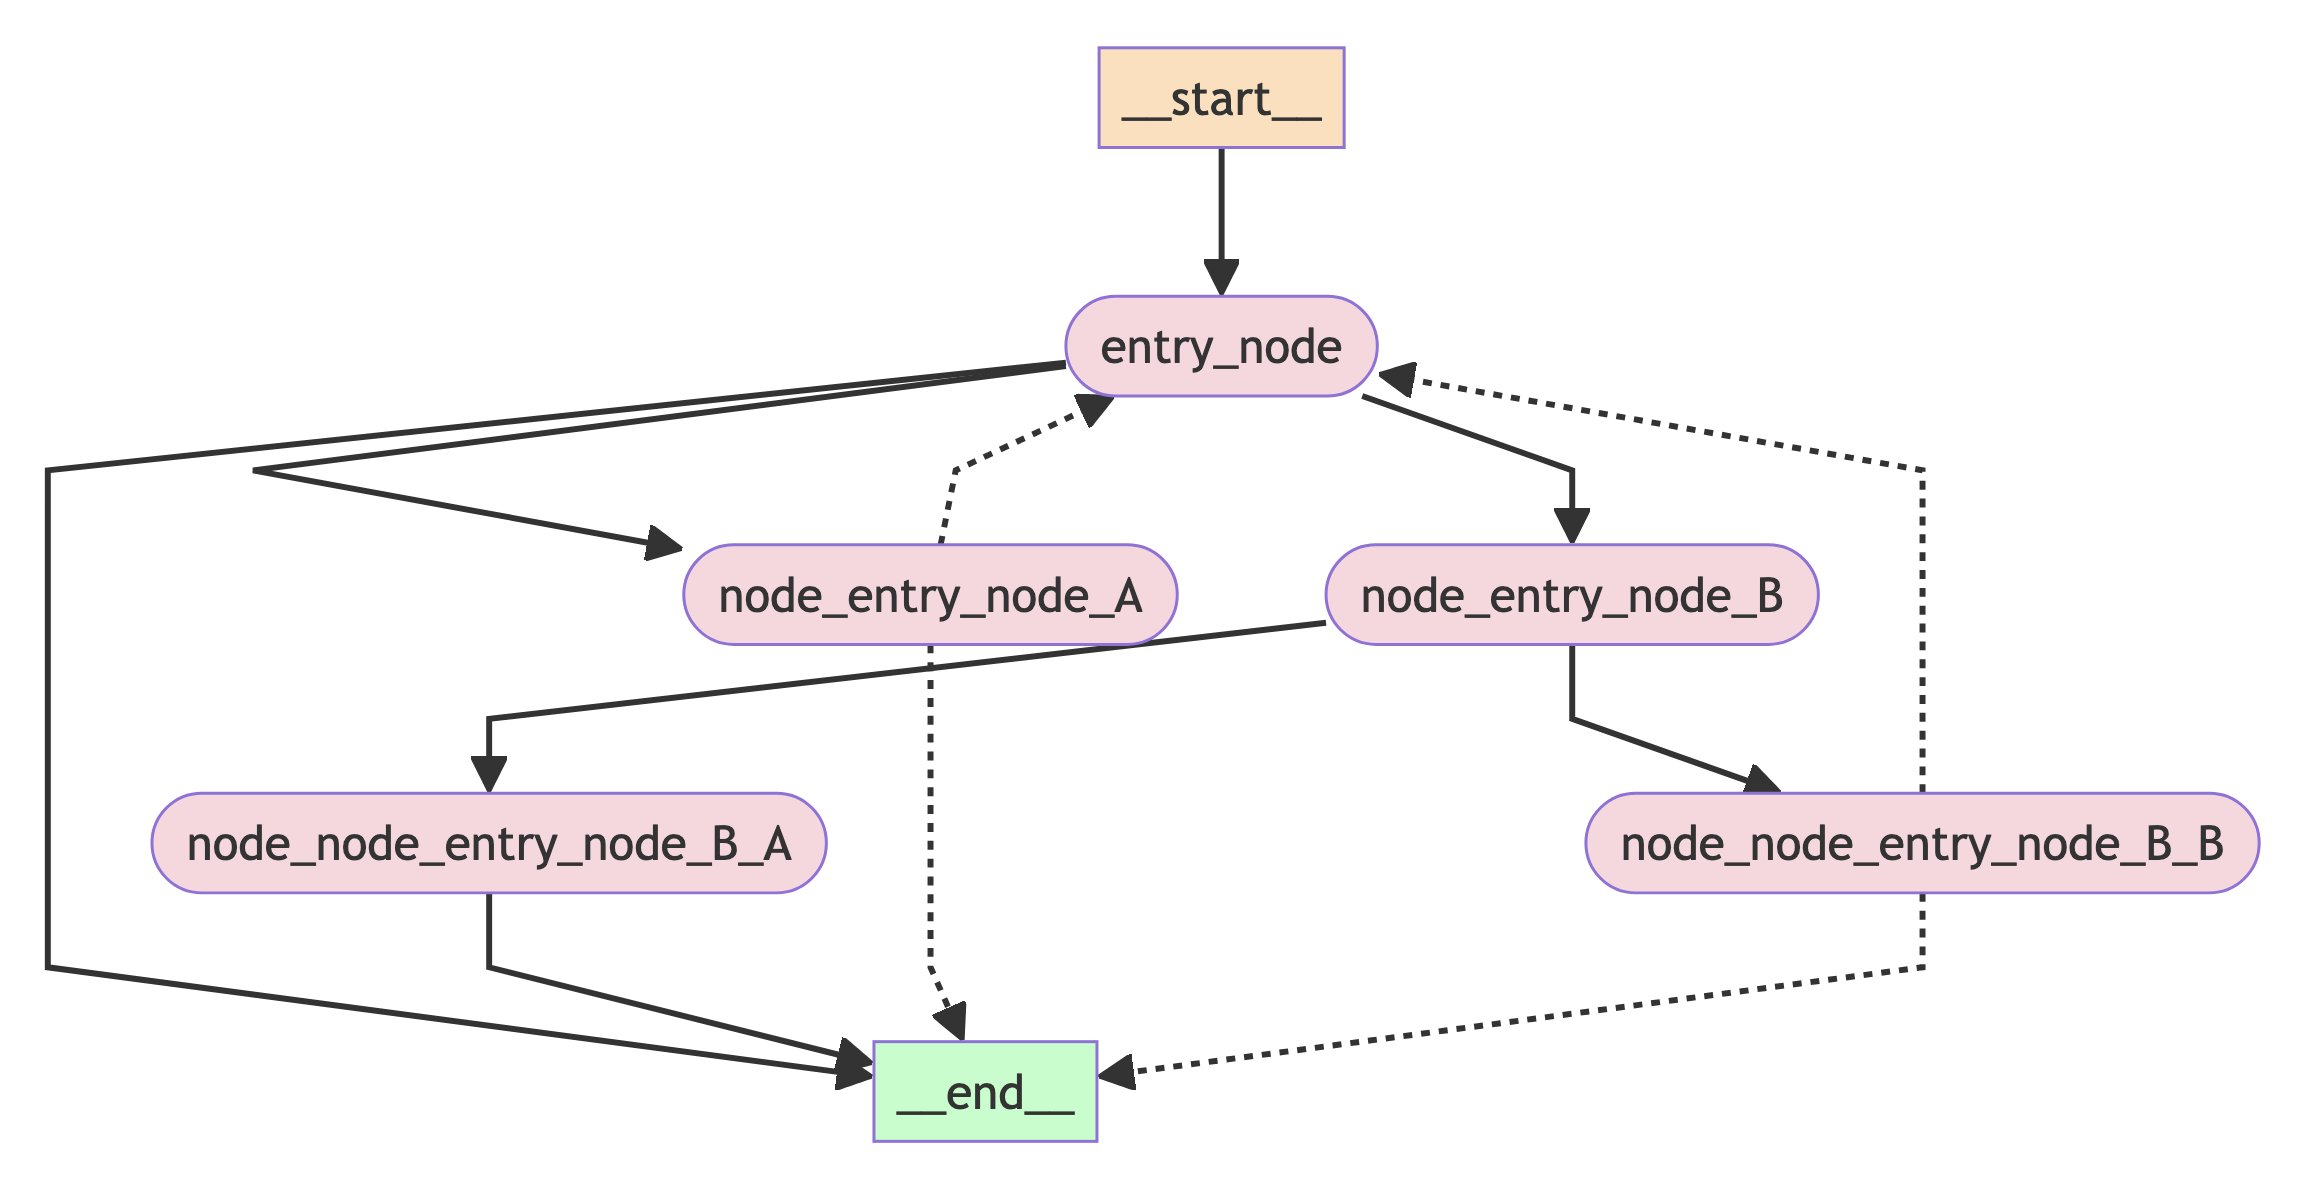

In [6]:
import nest_asyncio

nest_asyncio.apply()  # Required for Jupyter Notebook to run async functions

display(
    Image(
        app.get_graph().draw_mermaid_png(
            curve_style=CurveStyle.LINEAR,
            node_colors=NodeColors(start="#ffdfba", end="#baffc9", other="#fad7de"),
            wrap_label_n_words=9,
            output_file_path=None,
            draw_method=MermaidDrawMethod.PYPPETEER,
            background_color="white",
            padding=10,
        )
    )
)

### Using Graphviz

In [7]:
%%capture --no-stderr
%pip install pygraphviz

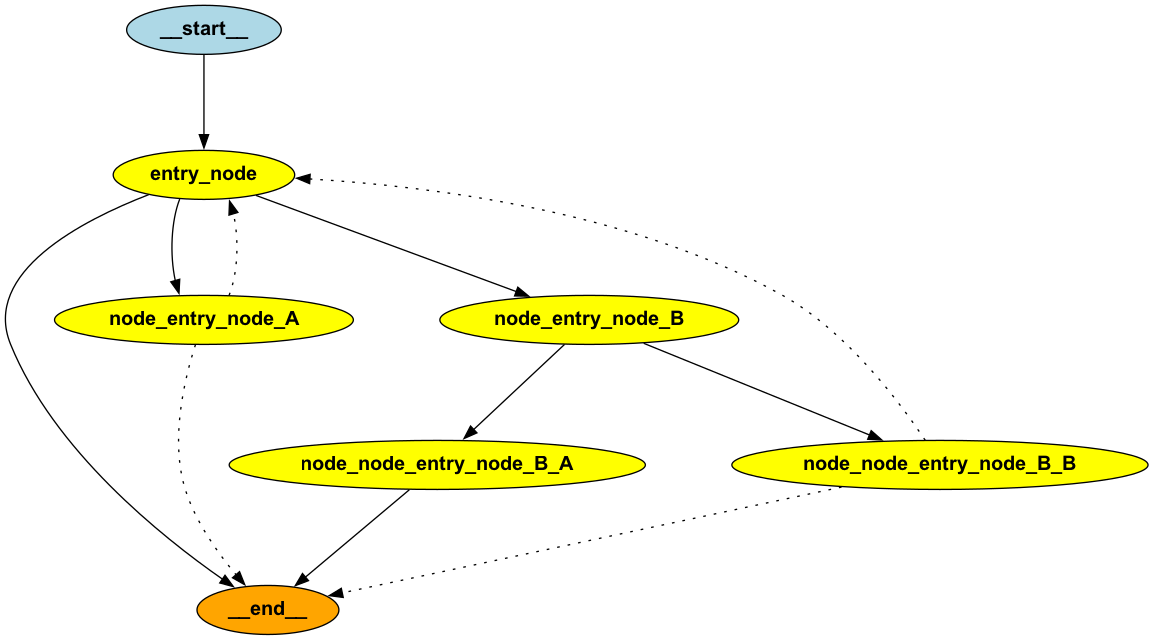

In [8]:
display(Image(app.get_graph().draw_png()))